In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import multiprocessing as mp
from sklearn.neighbors import KernelDensity
from sklearn.cluster import estimate_bandwidth

from IPython.display import display, Latex

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 

### Time to get your hands dirty! Fun with Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



#### Python tip. Web request and smarter file reading

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
values = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
values.shape

(15, 8413)

In [4]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [5]:
data = dict(zip(names, values))

# Code

## 1) Exploring the dataset

The following function is just for plotting

In [6]:
def kde_sklearn(data, x_dense, kernel="epanechnikov"):
    bandwidth = estimate_bandwidth(data[:, np.newaxis], n_jobs=int(mp.cpu_count()/2))
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_dense[:, np.newaxis]) # Sklearn returns log(density)

    return np.exp(log_pdf), bandwidth


def Plot1D(data, data_err=None, x_label='', y_label='', x_min=None, x_max=None):
    if x_min==None: x_min = np.min(data)
    if x_max==None: x_max = np.max(data)
    
    if data_err is None:
        plt.rcParams['figure.figsize'] = [8 , 8]
        fig, axes = plt.subplots(1, 1)
        ax = axes
    else:  
        plt.rcParams['figure.figsize'] = [16 , 8]
        fig, axes = plt.subplots(1, 2)
        ax = axes[0]

    x_dense = np.linspace(x_min, x_max, 1000)
    KDE, bandwidth = kde_sklearn(data, x_dense, kernel="epanechnikov") 
    ax.plot(x_dense, KDE, color='royalblue') 
    ax.set_xlabel(x_label)
    ax.set_ylabel(f'KDE (bandwidth={bandwidth:.3f})')
    ax.set_xlim(0.99*x_min, 1.01*x_max)


    if data_err is not None:
        ax = axes[1]
        ax.scatter(data, data_err, s=15, color='gray', edgecolor='black', linewidth=0.5, alpha=0.5)
        ax.plot([x_min, x_max], [x_min, x_max], color='red', ls='--')
        ax.set_ylim(0.99*x_min, 1.01*x_max)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
    
    return fig, axes

In [7]:
def Plot2D(x_data, y_data, x_label='', y_label='', nbins=100, x_min=None, x_max=None, y_min=None, y_max=None, xlog=False, ylog=False):
    plt.rcParams['figure.figsize'] = [16 , 8]
    fig, axes = plt.subplots(1, 2)

    if x_min==None: x_min = np.min(x_data)
    if x_max==None: x_max = np.max(x_data)
    if y_min==None: y_min = np.min(y_data)
    if y_max==None: y_max = np.max(y_data)


    ax = axes[0]
    ax.scatter(x_data, y_data, s=15, color='gray', edgecolor='black', linewidth=0.5, alpha=0.5)  
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if xlog==True: 
        ax.set_xscale('log')
        ax.set_xlim(0.5*x_min, 1.5*x_max)
    else: 
        ax.set_xlim(0.99*x_min, 1.01*x_max)
    
    if ylog==True: 
        ax.set_yscale('log')
        ax.set_ylim(0.5*y_min, 1.5*y_max)
    else:
        ax.set_ylim(0.95*y_min, 1.05*y_max)


    ax = axes[1]
    if xlog==True: 
        binx = np.logspace(start=np.log10(x_min), stop=np.log10(x_max), num=nbins)
        ax.set_xscale('log')
        ax.set_xlim(0.5*x_min, 1.5*x_max)
    else: 
        binx = np.linspace(start=x_min, stop=x_max, num=nbins)
        ax.set_xlim(0.99*x_min, 1.01*x_max)
        
    if ylog==True: 
        biny = np.logspace(start=np.log10(y_min), stop=np.log10(y_max), num=nbins)
        ax.set_yscale('log')
        ax.set_ylim(0.5*y_min, 1.5*y_max)
    else:
        biny = np.linspace(start=y_min, stop=y_max, num=nbins)
        ax.set_ylim(0.95*y_min, 1.05*y_max)
    
    if (xlog==True or ylog==True): 
        hist = ax.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)  
    else:
        hist = ax.hist2d(x_data, y_data, bins=(binx, biny), cmap=plt.cm.jet)
        
    cax = fig.add_axes([0.91, 0.11, 0.02, 0.77])
    fig.colorbar(hist[3], cax=cax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    return fig, axes

### 1.1) Right ascension

ra = [ 13.69  227.67  285.44  ... 201.3   193.475 270.675]


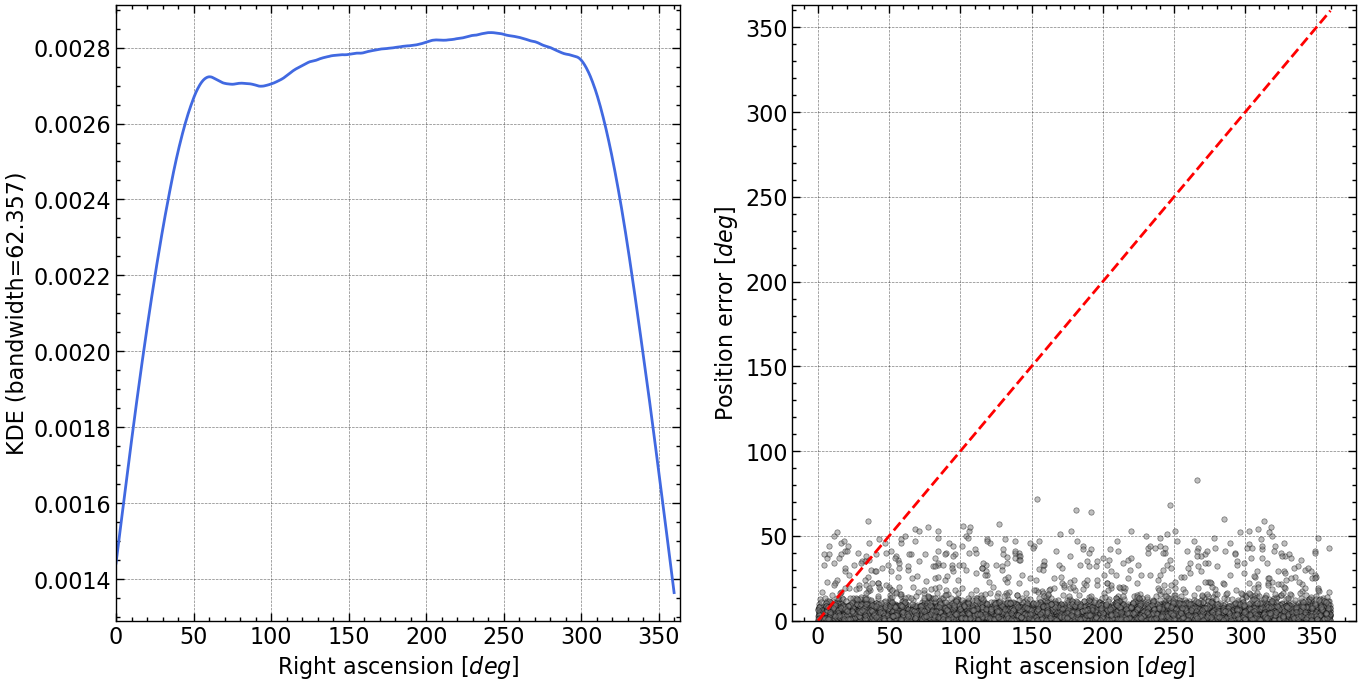

In [8]:
ra = np.array(data['ra'], dtype=float)
pos_error = np.array(data['pos_error'], dtype=float)
print(f'ra = {ra}')
fig, axes = Plot1D(ra, pos_error, 
                   x_label='Right ascension $[deg]$', y_label='Position error $[deg]$')

### 1.2) Declination

decl = [ 18.49    46.68    50.2    ... -45.4167  -8.3833  24.7667]


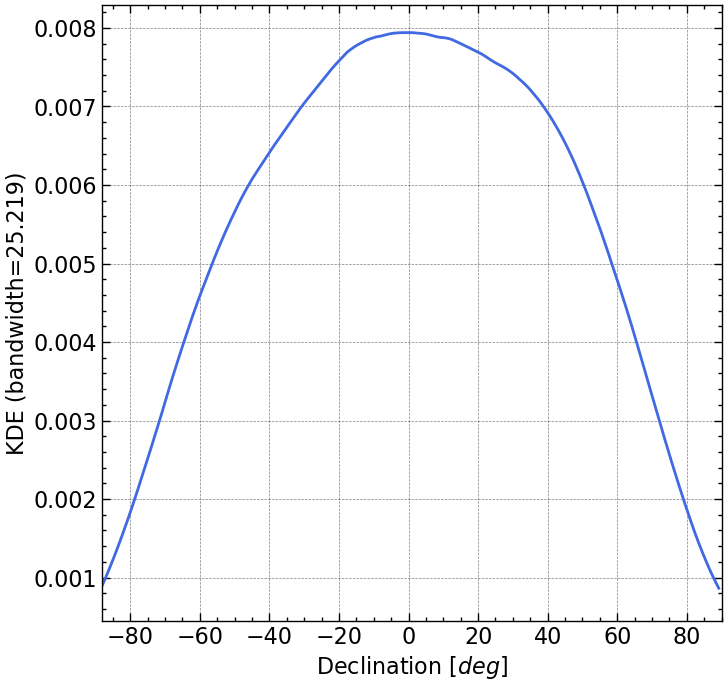

In [9]:
decl = np.array(data['decl'], dtype=float)
print(f'decl = {decl}')
fig, axes = Plot1D(decl, x_label='Declination $[deg]$')

### 1.3) T90

In [10]:
T90 = np.array(data['T90'], dtype=float)
mask_T90 = T90 > 0
T90_err = np.array(data['T90_error'], dtype=float)
print(f'Discarded {np.sum(~mask_T90)} points over {len(T90)}.')
print(f'T90 = {T90[mask_T90]}')
print(f'T90_err = {T90_err[mask_T90]}')

Discarded 1058 points over 8413.
T90 = [  2.048  37.377  42.753 ...   3.136 208.576   5.184]
T90_err = [0.905 2.429 2.919 ... 0.59  1.118 0.181]


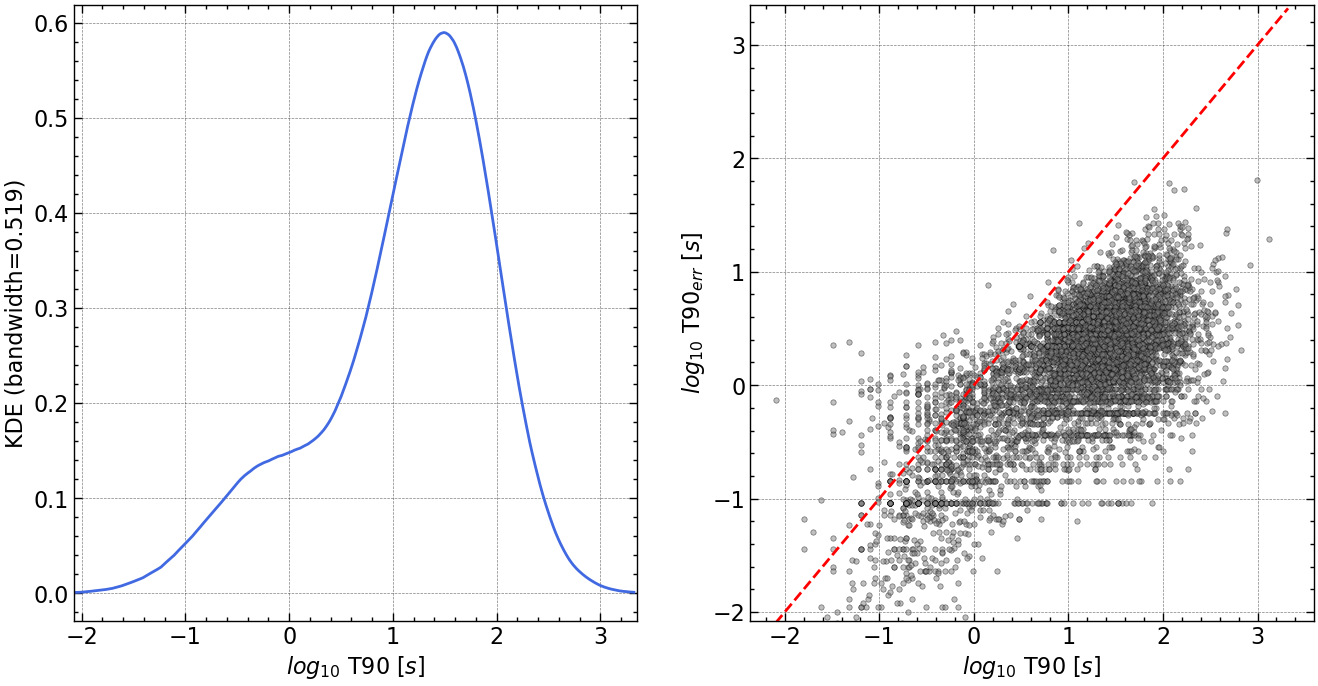

In [11]:
temp = T90_err[mask_T90].copy()
temp[temp>0] = np.log10(temp[temp>0])
fig, axes = Plot1D(np.log10(T90[mask_T90]), temp, 
                   x_label='$log_{10}$ T90 $[s]$', y_label='$log_{10}$ T90$_{err}$ $[s]$')

### 1.4) Fluence

In [12]:
fluence = np.array(data['fluence'], dtype=float)
mask_fluence = fluence > 0
fluence_err = np.array(data['fluence_error'], dtype=float)
print(f'Discarded {np.sum(~mask_fluence)} points over {len(fluence)}.')
print(f'fluence = {fluence[mask_fluence]}')
print(f'fluence_err = {fluence_err[mask_fluence]}')

Discarded 985 points over 8413.
fluence = [5.7502e-07 5.8068e-06 3.3510e-06 ... 2.4858e-08 1.6510e-07 2.6055e-06]
fluence_err = [1.2548e-08 3.9844e-08 2.3529e-08 ... 1.0496e-08 1.7015e-08 1.8857e-08]


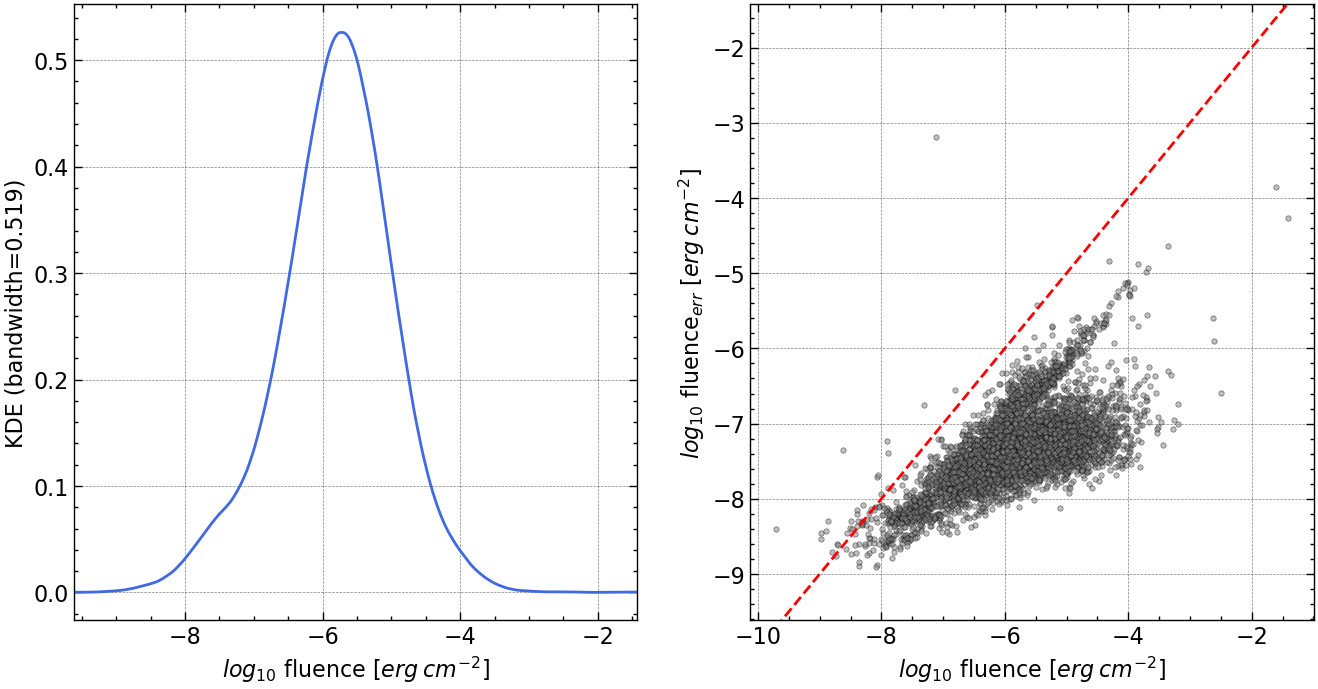

In [13]:
temp = fluence_err[mask_fluence].copy()
temp[temp>0] = np.log10(temp[temp>0])
fig, axes = Plot1D(np.log10(fluence[mask_fluence]), temp, 
                   x_label='$log_{10}$ fluence $[erg \: cm^{-2}]$', y_label='$log_{10}$ fluence$_{err}$ $[erg \: cm^{-2}]$')

### 1.5) Redshift

In [14]:
redshift = np.array(data['redshift'], dtype=float)
mask_redshift = redshift > 0
print(f'Discarded {np.sum(~mask_redshift)} points over {len(redshift)}.')

Discarded 7804 points over 8413.


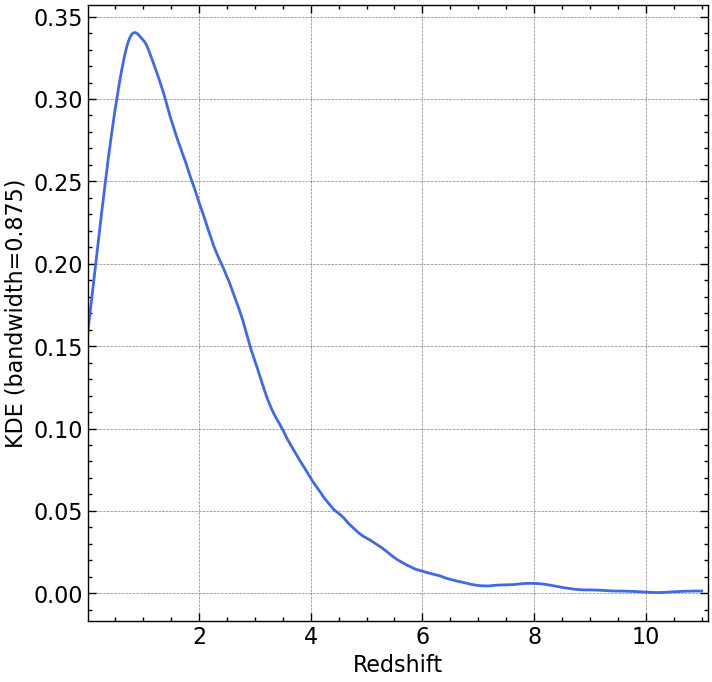

In [15]:
fig, axes = Plot1D(redshift[mask_redshift], x_label='Redshift')

### 1.6) T100

In [16]:
T100 = np.array(data['\'T100\''], dtype=float)
mask_T100 = T100 > 0
print(f'Discarded {np.sum(~mask_T100)} points over {len(T100)}.')

Discarded 1058 points over 8413.


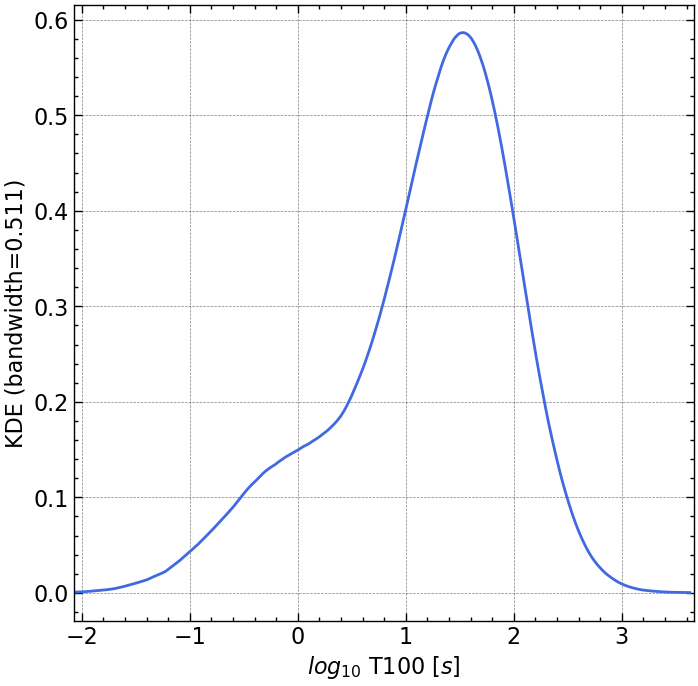

In [17]:
fig, axes = Plot1D(np.log10(T100[mask_T100]), x_label='$log_{10}$ T100 $[s]$')

## 2) Seaching for relations

ra = [ 13.69  227.67  285.44  ... 201.3   193.475 270.675]
decl = [ 18.49    46.68    50.2    ... -45.4167  -8.3833  24.7667]


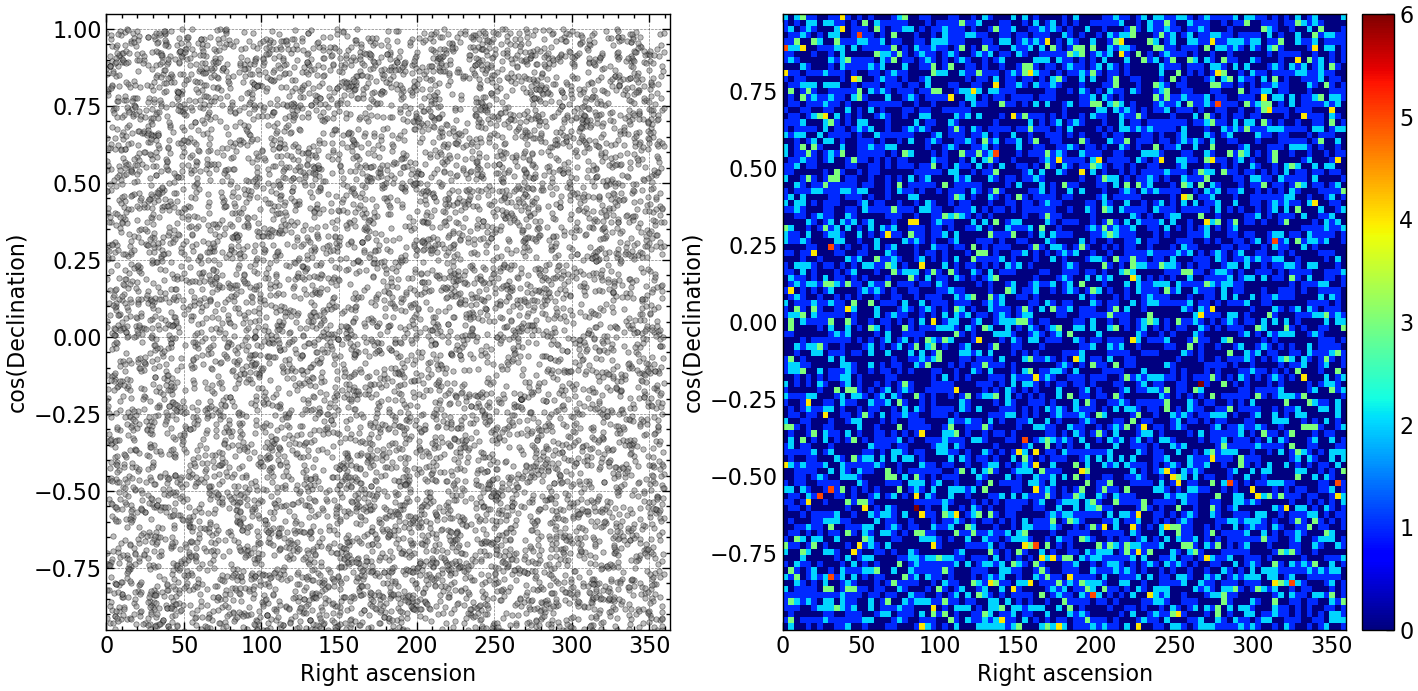

In [18]:
ra = np.array(data['ra'], dtype=float)
print(f'ra = {ra}')

decl = np.array(data['decl'], dtype=float)
print(f'decl = {decl}')

fig, axes = Plot2D(ra, np.cos(np.pi/2+np.deg2rad(decl)), x_label='Right ascension', y_label='cos(Declination)')

fluence = [5.7502e-07 5.8068e-06 3.3510e-06 ... 2.4858e-08 1.6510e-07 2.6055e-06]
fluence_err = [1.2548e-08 3.9844e-08 2.3529e-08 ... 1.0496e-08 1.7015e-08 1.8857e-08]
Discarded 985 points


Saved 7237 points


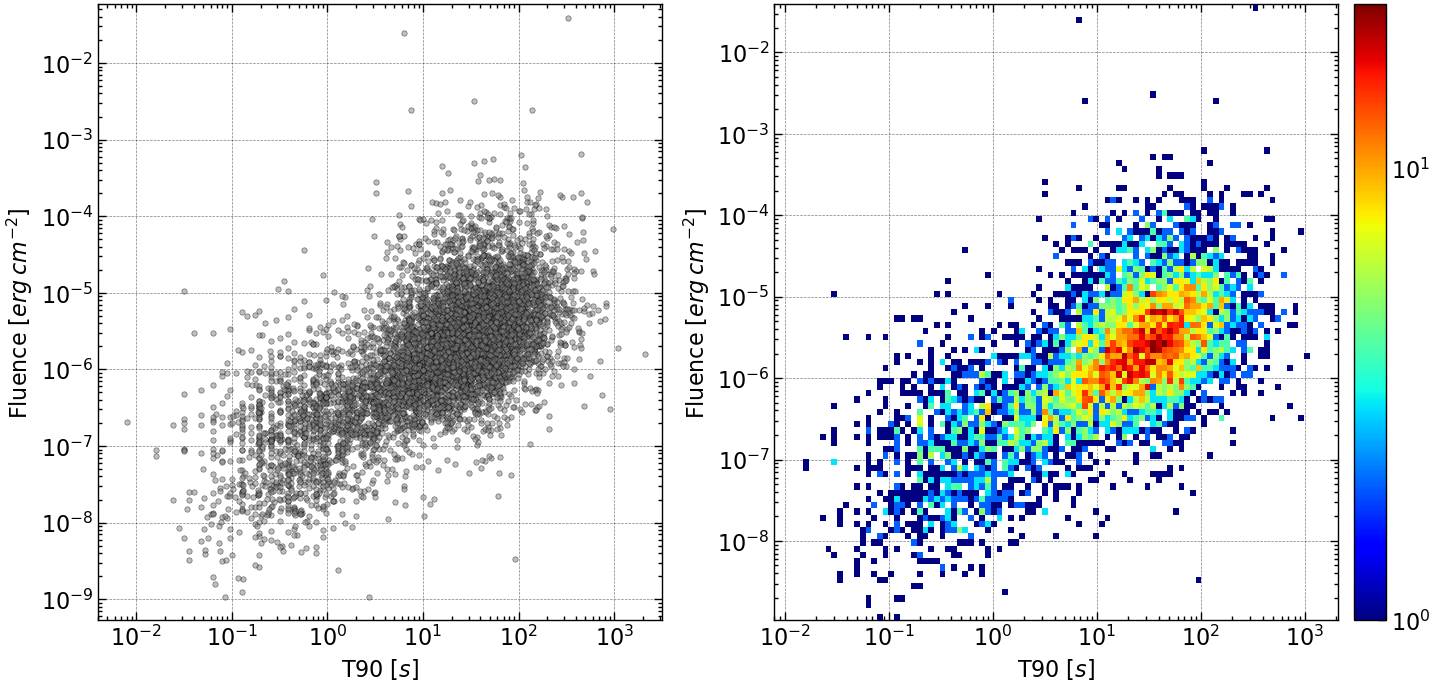

In [19]:
fluence = np.array(data['fluence'], dtype=float)
mask_fluence = fluence > 0
fluence_err = np.array(data['fluence_error'], dtype=float)
print(f'fluence = {fluence}')
print(f'fluence_err = {fluence_err}')
print(f'Discarded {np.sum(~mask_fluence)} points')

print('\n')

mask = np.array(mask_T90 & mask_fluence)
print(f'Saved {np.sum(mask)} points')


fig, axes = Plot2D(T90[mask], fluence[mask], x_label='T90 $[s]$', y_label='Fluence $[erg \: cm^{-2}]$', xlog=True, ylog=True)

redshift = [-999. -999. -999. ... -999. -999. -999.]
Discarded 7804 points


Saved 567 points


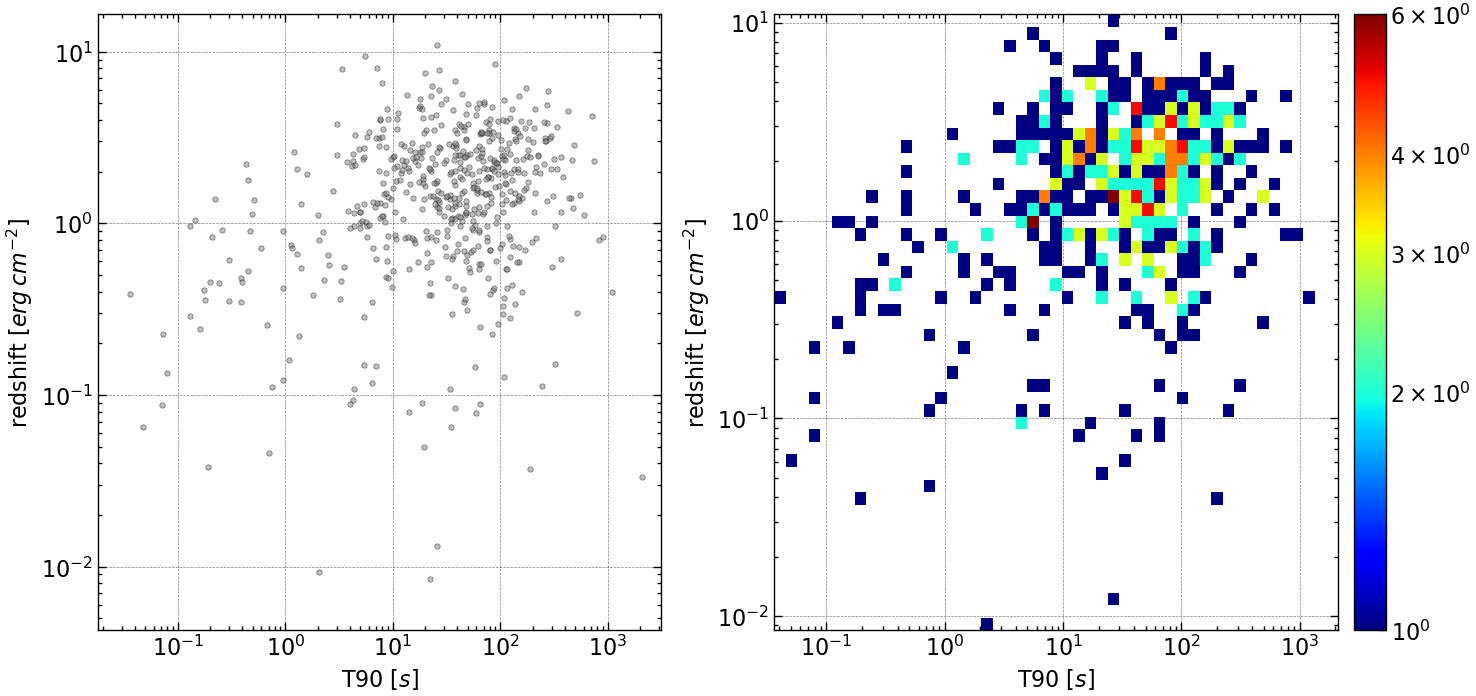

In [20]:
redshift = np.array(data['redshift'], dtype=float)
mask_redshift = redshift > 0
print(f'redshift = {redshift}')
print(f'Discarded {np.sum(~mask_redshift)} points')

print('\n')

mask = np.array(mask_T90 & mask_redshift)
print(f'Saved {np.sum(mask)} points')


fig, axes = Plot2D(T90[mask], redshift[mask], x_label='T90 $[s]$', y_label='redshift $[erg \: cm^{-2}]$', xlog=True, ylog=True, nbins=50)

## 3) Fluence vs T90

### 2.1) KMeans

[KMeans Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [21]:
def PlotClusters(X, labels):
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique[labels_unique >= 0])
    print(f'labels = {labels_unique}')
    print("number of estimated clusters :", n_clusters)
    
    fig = plt.figure(figsize=(8,8))
    plt.scatter(X[labels==-1,0], X[labels==-1,1], color='gray', alpha=0.5)
    for i in range(n_clusters):
        plt.scatter(X[labels==i,0], X[labels==i,1], alpha=0.5)
    
    return fig

(7237, 2)
labels = [0 1]
number of estimated clusters : 2


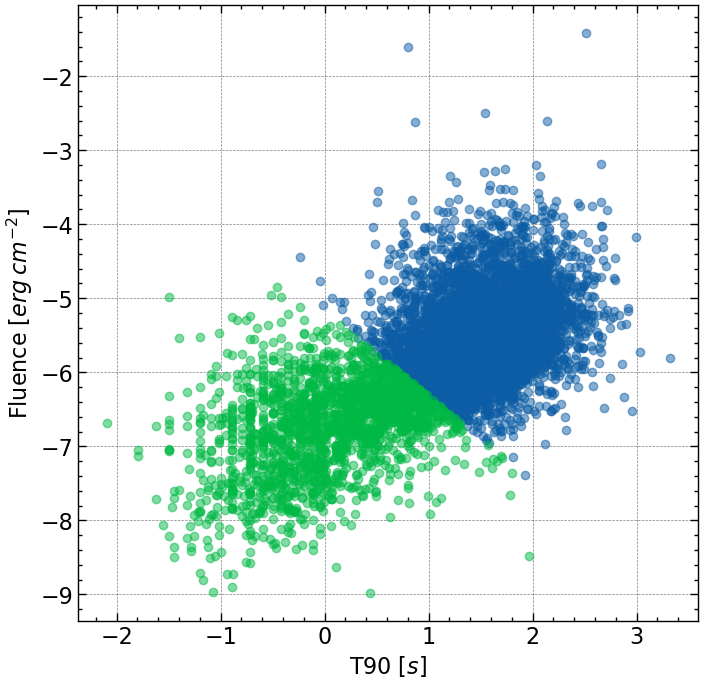

In [22]:
from sklearn.cluster import KMeans

mask = np.array(mask_T90 & mask_fluence)
X = np.array([np.log10(T90[mask]), np.log10(fluence[mask])]).T
print(X.shape)

n_clusters = 2
clf = KMeans(n_clusters=n_clusters, init='k-means++', n_init=100, tol=1e-9, verbose=False)
clf.fit(X)
labels = clf.predict(X)     

PlotClusters(X, labels)
plt.xlabel('T90 $[s]$')
plt.ylabel('Fluence $[erg \: cm^{-2}]$');

### 2.2) MeanShift

[MeanShift Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)

[estimate_bandwidth Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.estimate_bandwidth.html)

In [23]:
from sklearn.cluster import MeanShift
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

bandwidth = estimate_bandwidth(X, n_jobs=int(mp.cpu_count()/2))

In [24]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False, n_jobs=int(mp.cpu_count()/2))
ms.fit(scaler.fit_transform(X))

labels = ms.labels_

labels = [-1  0  1  2  3]
number of estimated clusters : 4


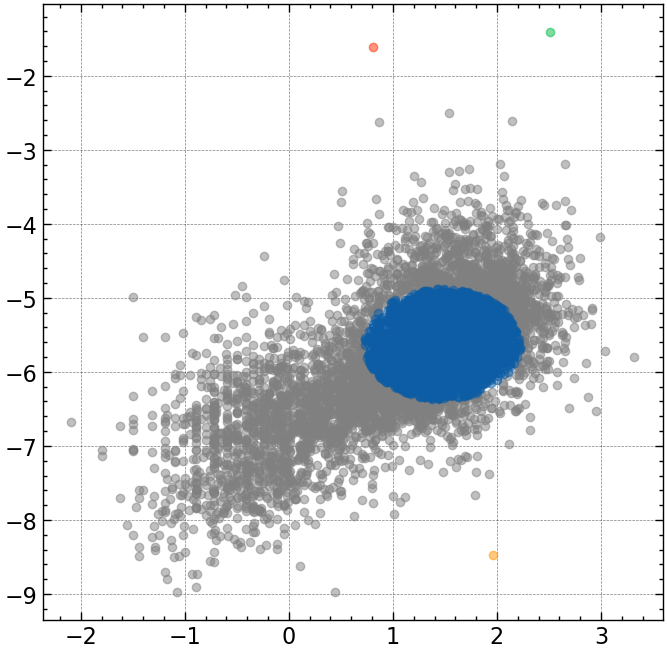

In [25]:
fig = PlotClusters(X, labels)

In [26]:
# Cross validation
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.01,1.0, 40) # Test 30 bandwidths from 0.1 to 1.0
print(bwrange)
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(x[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

[0.01       0.03538462 0.06076923 0.08615385 0.11153846 0.13692308
 0.16230769 0.18769231 0.21307692 0.23846154 0.26384615 0.28923077
 0.31461538 0.34       0.36538462 0.39076923 0.41615385 0.44153846
 0.46692308 0.49230769 0.51769231 0.54307692 0.56846154 0.59384615
 0.61923077 0.64461538 0.67       0.69538462 0.72076923 0.74615385
 0.77153846 0.79692308 0.82230769 0.84769231 0.87307692 0.89846154
 0.92384615 0.94923077 0.97461538 1.        ]


NameError: name 'x' is not defined